In [117]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred


In [118]:
# Define the date range for analysis
start_date = '1993-01-01'
end_date = '2024-12-31'

# Download S&P 500 data from Yahoo Finance
sp500 = yf.download("^GSPC", start=start_date, end=end_date)

# For our purposes, we might only need the adjusted closing prices
sp500 = sp500[['Close']]
sp500.columns = sp500.columns.droplevel(1)
sp500.rename(columns={'Close': 'SP500_Close'}, inplace=True)
print("S&P 500 data:")
print(sp500)


[*********************100%***********************]  1 of 1 completed

S&P 500 data:
Price       SP500_Close
Date                   
1993-01-04   435.380005
1993-01-05   434.339996
1993-01-06   434.519989
1993-01-07   430.730011
1993-01-08   429.049988
...                 ...
2024-12-23  5974.069824
2024-12-24  6040.040039
2024-12-26  6037.589844
2024-12-27  5970.839844
2024-12-30  5906.939941

[8056 rows x 1 columns]


In [119]:
fred = Fred(api_key='d3aa2a04cde864f79c67555f702236af')

Inflation (CPI)

In [120]:

# Download the CPI data (monthly series)
cpi = fred.get_series('CPIAUCSL', observation_start=start_date, observation_end=end_date)

# Convert the CPI series to a DataFrame
cpi = cpi.to_frame(name='CPI')
cpi.index = pd.to_datetime(cpi.index)
print("CPI data:")
print(cpi.head())


CPI data:
              CPI
1993-01-01  142.8
1993-02-01  143.1
1993-03-01  143.3
1993-04-01  143.8
1993-05-01  144.2


In [121]:
cpi.rename_axis('Date', inplace=True)
print("CPI data with renamed index:")
print(cpi.head())

CPI data with renamed index:
              CPI
Date             
1993-01-01  142.8
1993-02-01  143.1
1993-03-01  143.3
1993-04-01  143.8
1993-05-01  144.2


In [122]:
# Resample S&P 500 data to monthly frequency (using the last available value each month)
sp500_monthly = sp500.resample('M').last()

C:\Users\Bruno\AppData\Local\Temp\ipykernel_16624\2111411423.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly = sp500.resample('M').last()


In [123]:
print("Original sp500 index levels:", sp500.index.nlevels)
print(sp500.index)


Original sp500 index levels: 1
DatetimeIndex(['1993-01-04', '1993-01-05', '1993-01-06', '1993-01-07',
               '1993-01-08', '1993-01-11', '1993-01-12', '1993-01-13',
               '1993-01-14', '1993-01-15',
               ...
               '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19',
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-26',
               '2024-12-27', '2024-12-30'],
              dtype='datetime64[ns]', name='Date', length=8056, freq=None)


In [124]:
print("S&P 500 index levels:", sp500_monthly.index.nlevels)
print("CPI index levels:", cpi.index.nlevels)


S&P 500 index levels: 1
CPI index levels: 1


In [125]:

# Merge the CPI data with S&P 500 monthly data using merge_asof with the closest match
merged_data = pd.merge_asof(sp500_monthly, cpi, left_on='Date', right_index=True, direction='nearest')
print("Merged data:")
print(merged_data.head())

Merged data:
            SP500_Close    CPI
Date                          
1993-01-31   438.779999  143.1
1993-02-28   443.380005  143.3
1993-03-31   451.670013  143.8
1993-04-30   440.190002  144.2
1993-05-31   450.190002  144.3


In [126]:
# Download the 3-Month Treasury Bill rate from FRED
tb3ms = fred.get_series('TB3MS', observation_start=start_date, observation_end=end_date)
tb3ms = tb3ms.to_frame(name='TB3MS')
tb3ms.index = pd.to_datetime(tb3ms.index)

# Merge TB3MS with our stock data (resampled to monthly frequency)
data = pd.merge_asof(sp500_monthly, tb3ms, left_index=True, right_index=True, direction='nearest')

# Calculate monthly S&P 500 return (percentage change)
data['SP500_Return'] = data['SP500_Close'].pct_change() * 100

# Calculate excess return: S&P 500 return minus risk-free rate (approximated monthly)


data['Excess_Return'] = data['SP500_Return'] - data['TB3MS']

print("Excess Return (first few rows):")
print(data[['SP500_Return', 'TB3MS', 'Excess_Return']].head())


Excess Return (first few rows):
            SP500_Return  TB3MS  Excess_Return
Date                                          
1993-01-31           NaN   2.93            NaN
1993-02-28      1.048363   2.95      -1.901637
1993-03-31      1.869730   2.87      -1.000270
1993-04-30     -2.541681   2.96      -5.501681
1993-05-31      2.271746   3.07      -0.798254


In [127]:
# CPI data was previously retrieved and merged.
# Ensure CPI data is in the dataset:
data = pd.merge_asof(data, cpi, left_index=True, right_index=True, direction='nearest')
print("Data with CPI added:")
print(data[['CPI']].head())


Data with CPI added:
              CPI
Date             
1993-01-31  143.1
1993-02-28  143.3
1993-03-31  143.8
1993-04-30  144.2
1993-05-31  144.3


In [128]:
# Download TED Spread (Default Spread) data from FRED
ted = fred.get_series('TEDRATE', observation_start=start_date, observation_end=end_date)
ted = ted.to_frame(name='TEDRATE')
ted.index = pd.to_datetime(ted.index)

# Since TED spread is available at a daily frequency, resample it to monthly (take the last observation each month)
ted_monthly = ted.resample('M').last()

# Merge TED spread data into our dataset
data = pd.merge_asof(data, ted_monthly, left_index=True, right_index=True, direction='nearest')
data.rename(columns={'TEDRATE': 'Default_Spread'}, inplace=True)
print("Data with Default Spread added:")
print(data[['Default_Spread']].head())


Data with Default Spread added:
            Default_Spread
Date                      
1993-01-31            0.35
1993-02-28            0.26
1993-03-31            0.36
1993-04-30            0.28
1993-05-31            0.31


C:\Users\Bruno\AppData\Local\Temp\ipykernel_16624\3522643961.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ted_monthly = ted.resample('M').last()


In [129]:
# Download SPY data and its dividend history from Yahoo Finance
spy = yf.Ticker("SPY")
spy_hist = spy.history(start=start_date, end=end_date)
spy_dividends = spy.dividends

# Resample dividend data to monthly total dividends
monthly_dividends = spy_dividends.resample('M').sum().to_frame(name='Dividends')

# For the price, use the monthly closing price from SPY data
spy_monthly = spy_hist['Close'].resample('M').last().to_frame(name='SPY_Close')

# Merge price and dividend data
spy_data = pd.merge(spy_monthly, monthly_dividends, left_index=True, right_index=True, how='left')
spy_data['Dividend_Yield'] = (spy_data['Dividends'] / spy_data['SPY_Close']) * 100  # in percentage

# Remove timezone information from the index
spy_data.index = spy_data.index.tz_localize(None)

print("SPY Dividend Yield (first few rows):")
print(spy_data[['SPY_Close', 'Dividends', 'Dividend_Yield']].head())

# Merge the computed dividend yield into the main dataset.
data = pd.merge_asof(data, spy_data['Dividend_Yield'], left_index=True, right_index=True, direction='nearest')
data.rename(columns={'Dividend_Yield': 'Market_Dividend_Yield'}, inplace=True)


C:\Users\Bruno\AppData\Local\Temp\ipykernel_16624\2566613445.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_dividends = spy_dividends.resample('M').sum().to_frame(name='Dividends')
C:\Users\Bruno\AppData\Local\Temp\ipykernel_16624\2566613445.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  spy_monthly = spy_hist['Close'].resample('M').last().to_frame(name='SPY_Close')


SPY Dividend Yield (first few rows):
            SPY_Close  Dividends  Dividend_Yield
Date                                            
1993-01-31  24.526072        NaN             NaN
1993-02-28  24.787729        NaN             NaN
1993-03-31  25.342964      0.213         0.84047
1993-04-30  24.694479      0.000         0.00000
1993-05-31  25.360487      0.000         0.00000


In [130]:
# Download VIX data from Yahoo Finance
vix = yf.download("^VIX", start=start_date, end=end_date)
vix = vix[['Close']]
vix.columns = vix.columns.droplevel(1)
vix.rename(columns={'Close': 'VIX'}, inplace=True)

# Resample VIX data to monthly frequency (using the last observation of each month)
vix_monthly = vix.resample('M').last()

# Merge VIX data into our dataset
data = pd.merge_asof(data, vix_monthly, left_index=True, right_index=True, direction='nearest')
data.rename(columns={'VIX': 'Market_Volatility'}, inplace=True)
print("Data with Market Volatility added:")
print(data[['Market_Volatility']].head())


[*********************100%***********************]  1 of 1 completed

Data with Market Volatility added:
            Market_Volatility
Date                         
1993-01-31              12.42
1993-02-28              13.16
1993-03-31              12.53
1993-04-30              12.42
1993-05-31              13.47



C:\Users\Bruno\AppData\Local\Temp\ipykernel_16624\1421693607.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix_monthly = vix.resample('M').last()


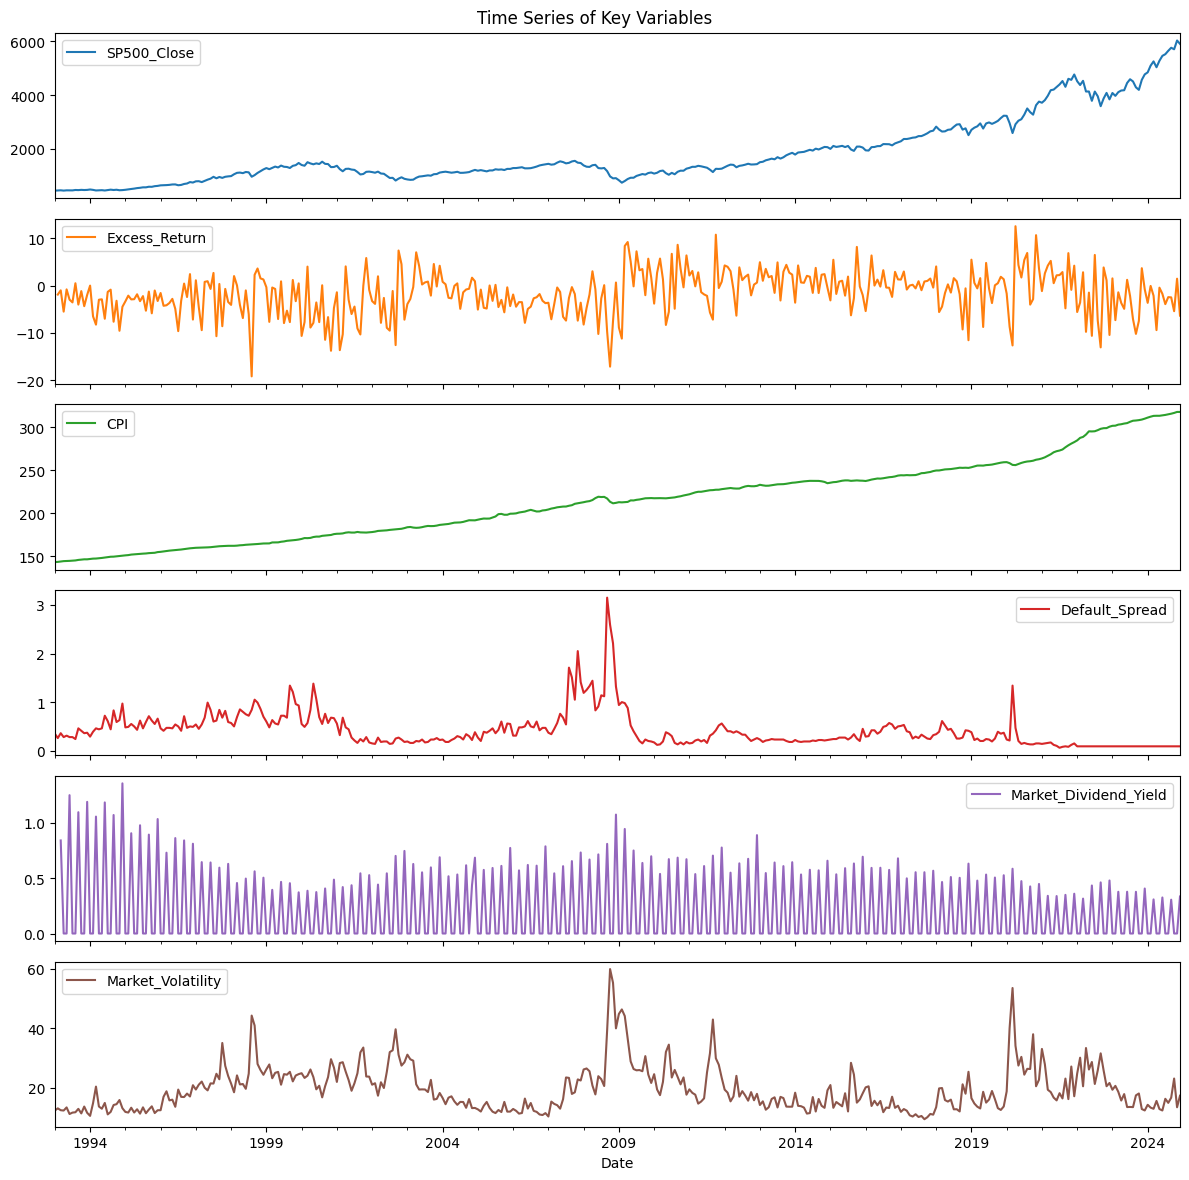

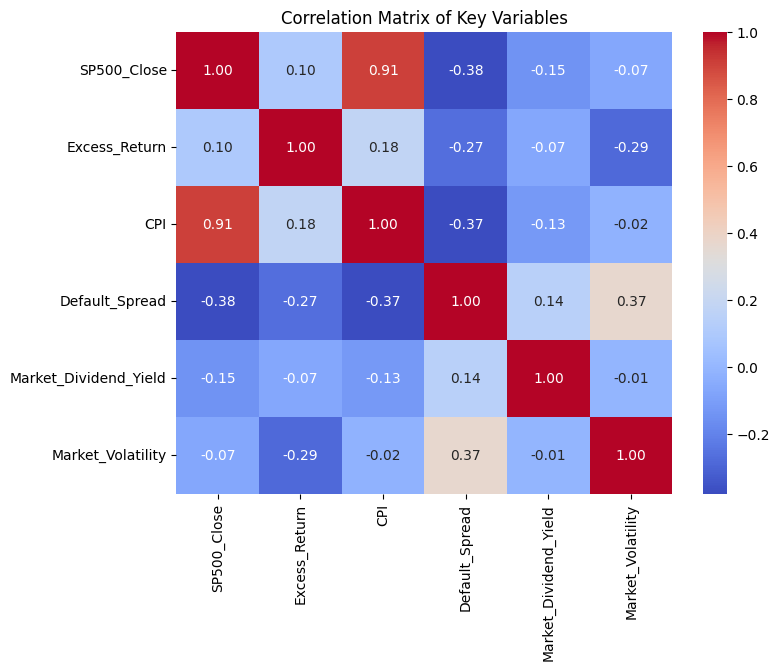

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Graph 1: Time Series Plots ---
# Define the columns to plot
cols_to_plot = ['SP500_Close', 'Excess_Return', 'CPI', 'Default_Spread', 
                'Market_Dividend_Yield', 'Market_Volatility']

# Create a multi-panel time series plot
data[cols_to_plot].plot(subplots=True, figsize=(12, 12), title='Time Series of Key Variables')
plt.tight_layout()
plt.show()

# --- Graph 2: Correlation Heatmap ---
# Compute the correlation matrix for the selected variables
corr_matrix = data[cols_to_plot].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Variables')
plt.show()


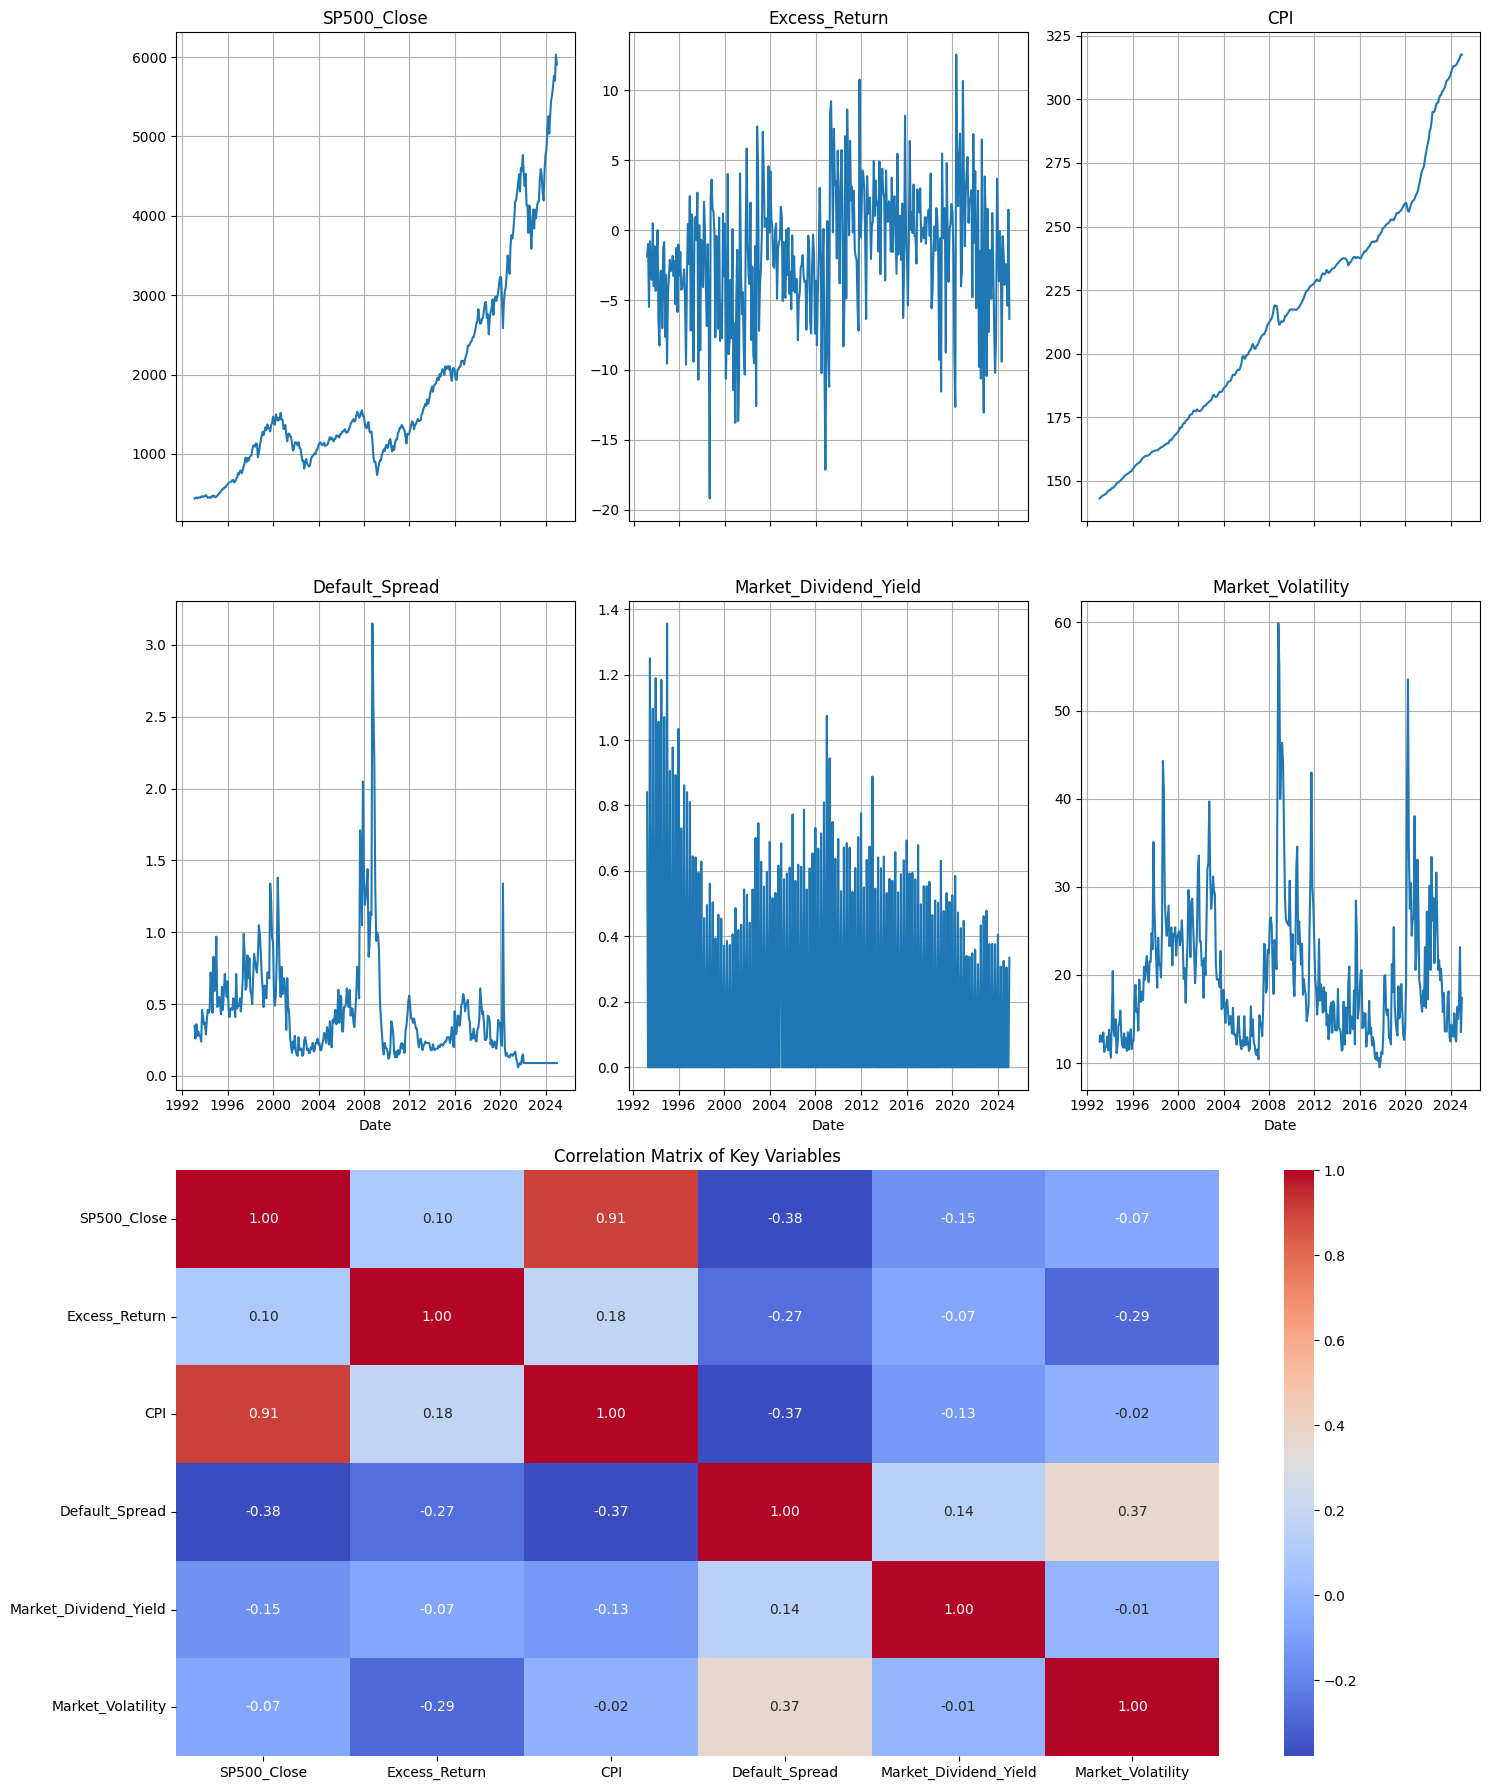

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Define the variables to plot
cols_to_plot = ['SP500_Close', 'Excess_Return', 'CPI', 'Default_Spread', 
                'Market_Dividend_Yield', 'Market_Volatility']

# Create a composite figure using GridSpec
fig = plt.figure(figsize=(15, 18))
# Allocate 3 rows: first 2 rows for time series (each row having 3 subplots), 
# and the 3rd row (spanning all 3 columns) for the correlation heatmap.
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1.2])

# --- Time Series Subplots ---
# Loop over each variable and plot it in a 2x3 grid.
for i, col in enumerate(cols_to_plot):
    # Compute row and column index for the subplot (for 6 subplots)
    row = i // 3  # will be 0 or 1
    col_idx = i % 3
    ax = fig.add_subplot(gs[row, col_idx])
    ax.plot(data.index, data[col])
    ax.set_title(col)
    ax.grid(True)
    # Optionally, adjust x-axis labels for clarity:
    if row == 1:
        ax.set_xlabel('Date')
    else:
        ax.set_xticklabels([])

# --- Correlation Heatmap ---
# Create a subplot that spans the entire third row
ax_heatmap = fig.add_subplot(gs[2, :])
corr_matrix = data[cols_to_plot].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax_heatmap)
ax_heatmap.set_title('Correlation Matrix of Key Variables')

plt.tight_layout()
plt.show()


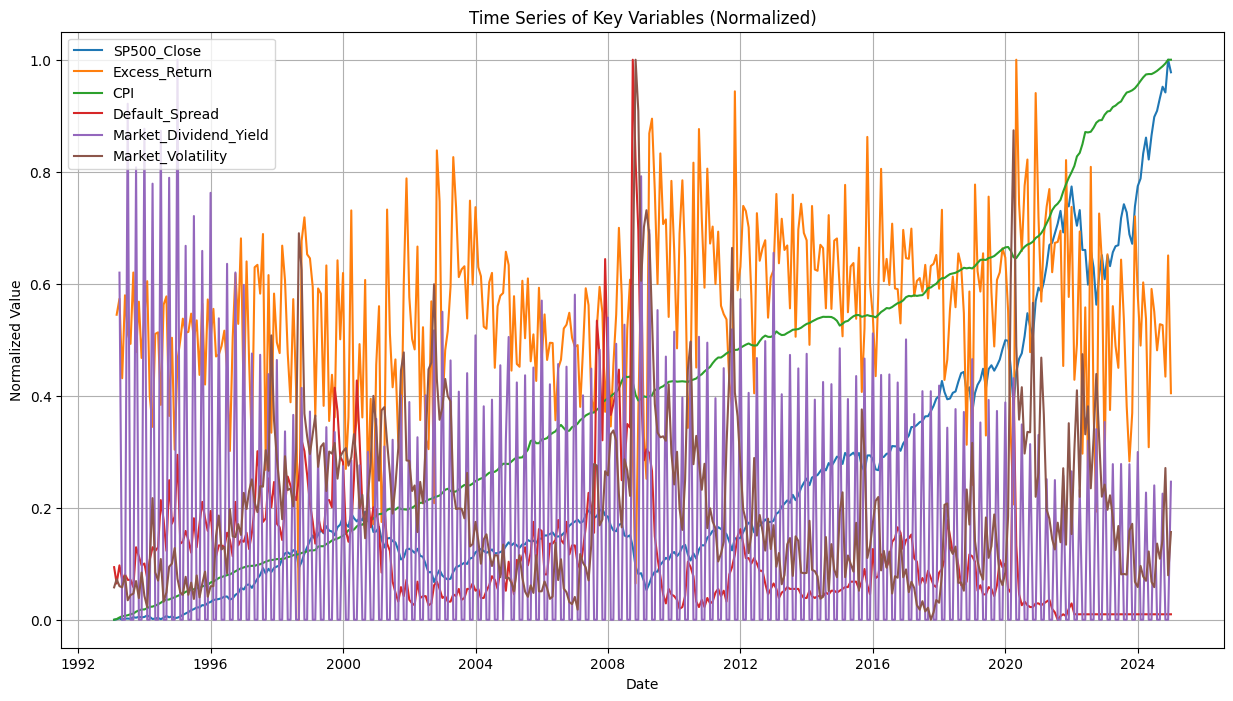

In [133]:
import matplotlib.pyplot as plt

# Define the columns you want to plot
cols_to_plot = ['SP500_Close', 'Excess_Return', 'CPI', 'Default_Spread', 
                'Market_Dividend_Yield', 'Market_Volatility']

# Normalize the data using min-max normalization for comparability
normalized_data = data[cols_to_plot].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.figure(figsize=(15, 8))
for col in normalized_data.columns:
    plt.plot(normalized_data.index, normalized_data[col], label=col)

plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.title("Time Series of Key Variables (Normalized)")
plt.legend()
plt.grid(True)
plt.show()


In [134]:
# Create binary indicator: 1 if Excess_Return >= 0, else 0
data['Y'] = (data['Excess_Return'] >= 0).astype(int)


In [135]:
# Create lagged predictors (shift by one period)
data['CPI_lag'] = data['CPI'].shift(1)
data['Default_Spread_lag'] = data['Default_Spread'].shift(1)
data['Market_Dividend_Yield_lag'] = data['Market_Dividend_Yield'].shift(1)
data['Market_Volatility_lag'] = data['Market_Volatility'].shift(1)

# Drop rows with missing values resulting from shifting
data.dropna(inplace=True)


In [136]:
import statsmodels.api as sm

# Define the independent variables (X) and dependent variable (y)
X = data[['CPI_lag', 'Default_Spread_lag', 'Market_Dividend_Yield_lag', 'Market_Volatility_lag']]
y = data['Y']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Build and fit the static probit model
probit_model = sm.Probit(y, X)
probit_result = probit_model.fit()

# Print a summary of the results
print(probit_result.summary())


Optimization terminated successfully.
         Current function value: 0.616010
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                      Y   No. Observations:                  381
Model:                         Probit   Df Residuals:                      376
Method:                           MLE   Df Model:                            4
Date:              dim., 02 mars 2025   Pseudo R-squ.:                 0.06909
Time:                        18:21:45   Log-Likelihood:                -234.70
converged:                       True   LL-Null:                       -252.12
Covariance Type:            nonrobust   LLR p-value:                 5.012e-07
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.7577      0.431     -4.077      0.000      -2.

dynamic

In [95]:
# Create the lagged dependent variable
data['Y_lag1'] = data['Y'].shift(1)

# Drop any new missing values
data.dropna(inplace=True)

# Define the dynamic model predictors (include lagged Y)
X_dynamic = data[['CPI_lag', 'Default_Spread_lag', 'Market_Dividend_Yield_lag', 'Market_Volatility_lag', 'Y_lag1']]
X_dynamic = sm.add_constant(X_dynamic)
y_dynamic = data['Y']

# Build and fit the dynamic probit model
dynamic_probit = sm.Probit(y_dynamic, X_dynamic)
dynamic_probit_result = dynamic_probit.fit()

# Print a summary of the dynamic model results
print(dynamic_probit_result.summary())


Optimization terminated successfully.
         Current function value: 0.606817
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                      Y   No. Observations:                  380
Model:                         Probit   Df Residuals:                      374
Method:                           MLE   Df Model:                            5
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                 0.08368
Time:                        00:31:01   Log-Likelihood:                -230.59
converged:                       True   LL-Null:                       -251.65
Covariance Type:            nonrobust   LLR p-value:                 5.584e-08
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.8644      0.440     -4.236      0.000      -2.

## ML

In [113]:
from sklearn.ensemble import RandomForestClassifier


Accuracy: 0.64
Confusion Matrix:
 [[50 15]
 [21 14]]
ROC AUC: 0.7094505494505495


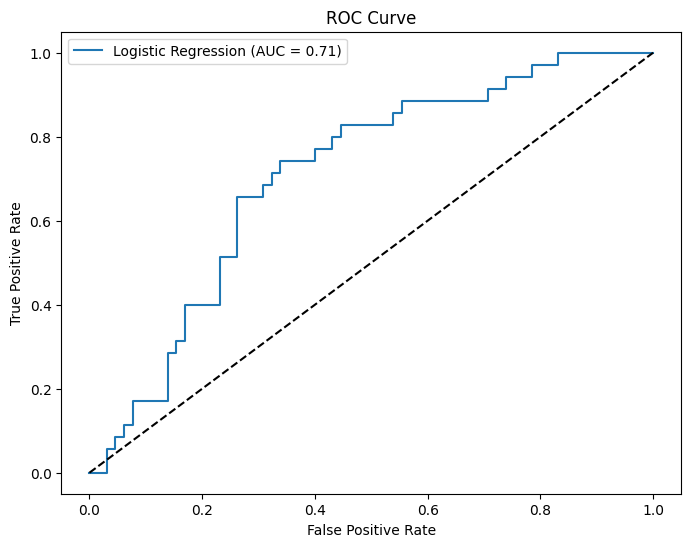

In [114]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Suppose 'data' is your DataFrame that includes the predictors and binary outcome 'Y'
# Using the lagged variables created in Step 3:
features = data[['CPI_lag', 'Default_Spread_lag', 'Market_Dividend_Yield_lag', 'Market_Volatility_lag']]
target = data['Y']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Instantiate and fit the logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)[:, 1]

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("ROC AUC:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='best')
plt.show()


In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Define features and target from your dataset
features = data[['CPI_lag', 'Default_Spread_lag', 'Market_Dividend_Yield_lag', 'Market_Volatility_lag']]
target = data['Y']

# Split the data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Instantiate and train the Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions and calculate probabilities
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate the model
acc_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print("Random Forest Accuracy:", acc_rf)
print("Random Forest ROC AUC:", roc_auc_rf)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.7
Random Forest ROC AUC: 0.6413186813186813
Confusion Matrix:
 [[51 14]
 [16 19]]


In [116]:
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate and train the Gradient Boosting classifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Make predictions and calculate probabilities
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

# Evaluate the model
acc_gb = accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)
print("Gradient Boosting Accuracy:", acc_gb)
print("Gradient Boosting ROC AUC:", roc_auc_gb)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.66
Gradient Boosting ROC AUC: 0.649010989010989
Confusion Matrix:
 [[47 18]
 [16 19]]


In [118]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the neural network model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))  # Dropout to reduce overfitting
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Use EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model (using 20% of the training data for validation)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Evaluate the model on the test set
nn_loss, nn_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Neural Network Test Accuracy:", nn_accuracy)

# Obtain predictions and compute ROC AUC
y_prob_nn = model.predict(X_test).ravel()
y_pred_nn = (y_prob_nn > 0.5).astype(int)
roc_auc_nn = roc_auc_score(y_test, y_prob_nn)
print("Neural Network ROC AUC:", roc_auc_nn)


Epoch 1/100


c:\Users\Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.3900 - loss: 19.3792 - val_accuracy: 0.4681 - val_loss: 9.1523
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4521 - loss: 9.9806 - val_accuracy: 0.4681 - val_loss: 1.9126
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4845 - loss: 6.3405 - val_accuracy: 0.5319 - val_loss: 3.8559
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6247 - loss: 4.8614 - val_accuracy: 0.5319 - val_loss: 5.2185
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5736 - loss: 5.3814 - val_accuracy: 0.5319 - val_loss: 3.8245
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5487 - loss: 5.2663 - val_accuracy: 0.5319 - val_loss: 1.3772
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4807 - loss: 4.4626 - val_accuracy: 0.5319 - val_loss: 0.7358
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5154 - loss: 4.6454 - val_accuracy: 0.5106 - val_loss: 0.7813
Epo